C:\Users\Josh\AppData\Local\Temp\ipykernel_8264\3837903797.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)


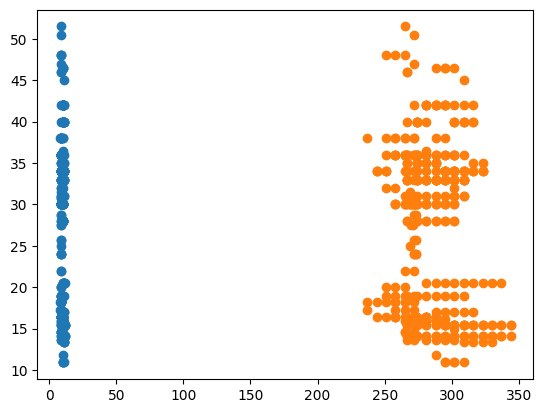

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('US-pumpkins.csv')

pumpkins.head()
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

columns_to_select = ['Package', 'Variety', 'City Name', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.loc[:, columns_to_select]

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()

import matplotlib.pyplot as plt
plt.scatter('Month','Price',data=new_pumpkins)
plt.scatter('DayOfYear','Price',data=new_pumpkins)

In [25]:
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.14878293554077546
-0.16673322492745407


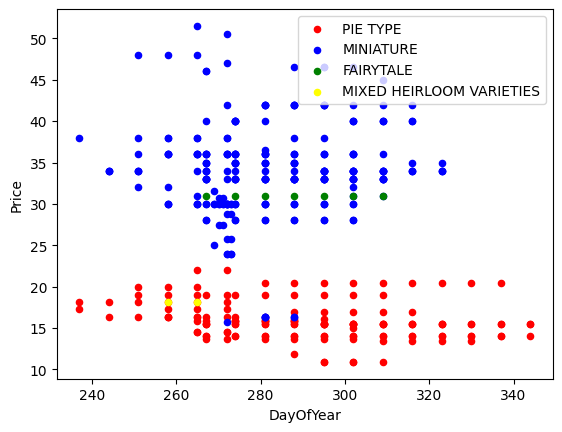

In [26]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    df = new_pumpkins[new_pumpkins['Variety']==var]
    ax = df.plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

<Axes: xlabel='Variety'>

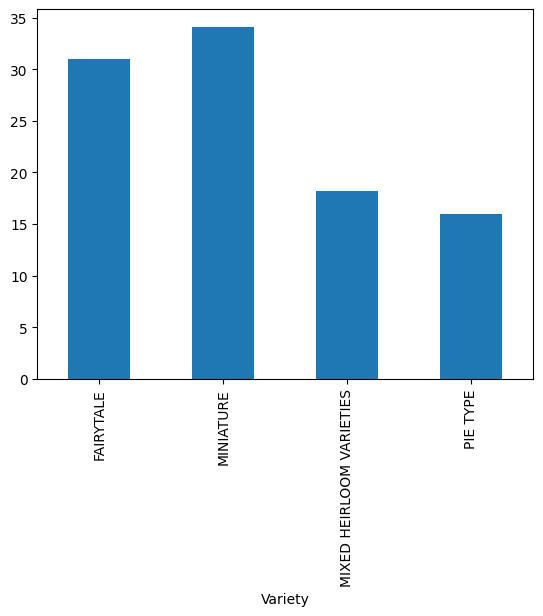

In [27]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

<Axes: xlabel='DayOfYear', ylabel='Price'>

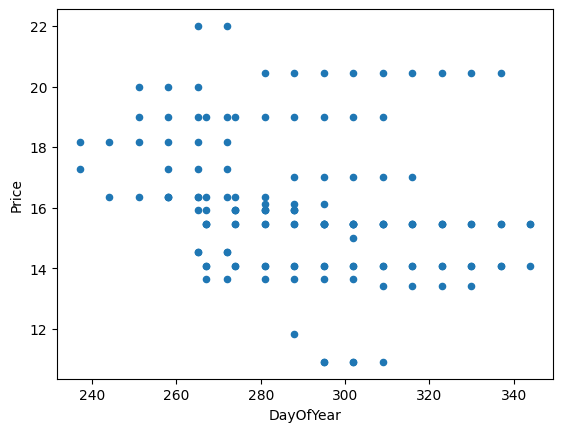

In [28]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']
pie_pumpkins.plot.scatter('DayOfYear','Price') 

In [29]:
pie_pumpkins.dropna(inplace=True)
pie_pumpkins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 70 to 1630
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    int32  
 1   DayOfYear   144 non-null    int64  
 2   Variety     144 non-null    object 
 3   City        144 non-null    object 
 4   Package     144 non-null    object 
 5   Low Price   144 non-null    float64
 6   High Price  144 non-null    float64
 7   Price       144 non-null    float64
dtypes: float64(3), int32(1), int64(1), object(3)
memory usage: 9.6+ KB


C:\Users\Josh\AppData\Local\Temp\ipykernel_8264\3144308612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pie_pumpkins.dropna(inplace=True)


In [30]:
# ---------------------------------------------- Linear Regression ----------------------------------------------

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [32]:
# Clean - Reshape data into two numpy arrays.
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

In [33]:
# Split dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [34]:
# Linear Regression Model
# The LinearRegression object after fit-ting contains all the coefficients of the regression, which can be accessed using .coef_ property
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)


LinearRegression()

In [35]:
# Test
pred = lin_reg.predict(X_test)
# MSE
mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

Mean error: 2.77 (17.2%)


In [36]:
# Coefficent Of Determination
score = lin_reg.score(X_train,y_train)
print('Model determination: ', score)

Model determination:  0.04460606335028361


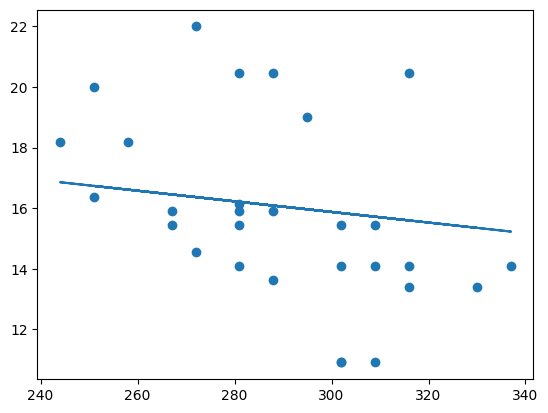

In [37]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

In [38]:
# ---------------------------------------------- Polynomial Regression ----------------------------------------------

In [39]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [40]:
# set up training data
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

# make train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# setup and train the pipeline
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())
pipeline.fit(X_train,y_train)

# predict results for test data
pred = pipeline.predict(X_test)

# calculate MSE and determination
mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.34 (8.62%)
Model determination:  0.9639157326371568


In [41]:
# ---------------------------------------------- Logistic Regression ----------------------------------------------

In [42]:
columns_to_select = ['City Name','Package','Variety', 'Origin','Item Size', 'Color']
pumpkins = full_pumpkins.loc[:, columns_to_select]
pumpkins.dropna(inplace=True)
pumpkins.info

NameError: name 'full_pumpkins' is not defined